# MobileNet V2 SSD Tensorflow로 구현해보기 실습
지난 실습 때 MobileNet V2를 이용하여 이미지 분류를 하는 모델을 학습하였다. 이번 실습에서는 조금 더 나아가 이미지 안의 물체를 탐지하는 네트워크를 실습해 볼 것이다. 지난 시간에 다뤘던 MobileNet V2에 SSD(Single Shot Detection)를 추가해 물체 탐지를 해보자. <br>

In [1]:
import os
import socket
import pickle
import time
import numpy as np
import struct
from tqdm import tqdm
from sys import getsizeof
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Add, ReLU, Input, Dense, Dropout, Activation, Flatten \
    , Conv2D, MaxPooling2D, InputLayer, Reshape, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.engine.topology import Input
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import CSVLogger

In [2]:
from tensorflow.python.keras import backend
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.applications import imagenet_utils

In [3]:
from sklearn import model_selection
import math

## Setting GPU
GPU가 없으면 아래 Step은 건너뛰어도 좋다.

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
idx = 0
tf.config.experimental.set_visible_devices(gpus[idx], 'GPU')
tf.config.experimental.set_memory_growth(gpus[idx], True)

## Setting Hyperparameters
SSD의 주요 Parameter들을 아래와 같이 설정해 주자.

In [5]:
IMG_SIZE = 224
n_classes = 10
pos_iou_threshold = 0.5
neg_iou_threshold = 0.5
score_threshold = 0.01
layer_width=[28,14,7,4,2,1]
num_boxes = [4,6,6,6,4,4]
aspect_ratio = [1,1,2,1/2,3,1/3]
s_max = 0.9
s_min = 0.2
batch_size = 32
log_dir = './'
model_name = 'mobilenetSSD'
model_csv_path  = os.path.join(log_dir, (model_name + '.csv'))

## Dataset

데이터셋은 cifar 10을 이용할 것이다. 다만, cifar 10은 이미지분류를 위한 데이터셋으로 Object detection 모델을 훈련시키기에는 적합하지 않으므로, 이를 적절하게 변형해주는 작업을 추가로 수행할 것이다. 먼저 데이터셋을 로드한다.

In [6]:
#Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

아래는 SSD 데이터 전처리를 위한 Utility function들이다. 
1. calc_iou <br>두 Bounding box를 Input으로 받아 IoU(Intersection over Union)을 계산한다. 입력된 array의 마지막 dimension의 마지막 4자리를 Bounding box로 보고, 입력 포맷은 Corner 스타일(xmin, ymin, xmax, ymax) 이어야 한다.
2. match_bipartite_greedy  <br>각 Ground Truth별로 가장 많이 겹치는 Anchor box를 찾기 위한 함수. (Ground Truth) x (Anchor boxes) 형태의 IoU Matrix를 입력으로 받아 각 Ground Truth마다 가장 IoU가 높은 Anchor box를 찾아준다.
3. match_multi  <br>match_bipartite_greedy에서는 해당되지 않지만, IoU가 높은 Anchor box들에 대해서도 Ground Truth를 매칭시켜주기 위한 함수.  각 Anchor box별로 iou가 특정 임계값보다 높은 Ground Truth 중 iou가 가장 높은 Ground Truth를 찾아준다.
4. convert_coord <br>좌표값 표현 포맷을 변환해주는 함수. Centroid(cx, cy, w, h)와 Corner(xmin, ymin, xmax, ymax) 스타일 간에 변환이 가능하다.

In [7]:
def calc_iou(gt, anchor_boxes):        
        """
        Calculate IOU of ground truth and anchor boxes
        
        Input:
            gt: ground truth image, shape: (#object per image, 4)
            anchor_boxes: anchor boxes, shape: (sum of grid size of all classifier * num_boxes, 4)
        Output:
            Matrix of iou. Row indicates each ground truth box and column indicates each anchor box.
            shape: (#object per image, sum of grid size of all classifier)        
        """      
        
        m = gt.shape[0] # Object per image
        n = anchor_boxes.shape[0] # Number of all boxes
        
        #Calculate min_xy
        min_xy = np.maximum(np.tile(np.expand_dims(gt[:,0:2], axis = 1), reps = (1,n,1)),
                            np.tile(np.expand_dims(anchor_boxes[:, 0:2], axis = 0), reps = (m,1,1)))
        
        #Calculate max_xy
        max_xy = np.minimum(np.tile(np.expand_dims(gt[:,2:4], axis = 1), reps = (1,n,1)),
                            np.tile(np.expand_dims(anchor_boxes[:, 2:4], axis = 0), reps = (m,1,1)))
        
        #calculate intersection
        intersection = np.maximum((max_xy - min_xy)[:,:,0],0) * np.maximum((max_xy - min_xy)[:,:,1],0)
        
        #calculate union
        edge_gt = np.tile(np.expand_dims(gt[:,2:4] - gt[:,0:2], axis = 1), reps = (1,n,1))         
        area_gt = edge_gt[:,:,0] * edge_gt[:,:,1]
        
        edge_anchor_boxes = np.tile(np.expand_dims(anchor_boxes[:,2:4] - anchor_boxes[:,0:2], axis = 0), reps = (m,1,1))         
        area_anchor_boxes = edge_anchor_boxes[:,:,0] * edge_anchor_boxes[:,:,1]

        union = area_gt + area_anchor_boxes - intersection
        
        return intersection / union

In [8]:
def match_bipartite_greedy(weight_matrix):
    """
    Calculate the highest matching anchor box per each ground truth
    Input: iou between each ground truth and anchor boxes, shape: (#gt, #anchor boxes)
    Output: List of matched anchor per each ground truth
    """
    m = weight_matrix.shape[0]
    n = weight_matrix.shape[1]
    
    matches = np.zeros(m, dtype = np.int)
    weight_cp = np.copy(weight_matrix)
    
    #Find the largest iou per each ground truth box in descending order
    for _ in range(m):
        largest_indices = np.argmax(weight_cp, axis = 1)
        iou_largest = weight_cp[list(range(m)), largest_indices]
        match_gt = np.argmax(iou_largest, axis = 0)
        match_anchor = largest_indices[match_gt]
        matches[match_gt] = match_anchor
        
        #Set the selected ground truth to 0, matched anchor box to 0 as well.
        weight_cp[match_gt, :] = 0
        weight_cp[:, match_anchor] = 0
        
    return matches    

In [9]:
def match_multi(weight_matrix, threshold):
    """
    Multiple object match
    From remaining anchor boxes, find the most similar ground truth 
    whose iou is greater than pos_threshold
    """
    m = weight_matrix.shape[0]
    n = weight_matrix.shape[1]

    #Find the largest iou per each anchor box
    largest_indices = np.argmax(weight_matrix, axis = 0)
    iou_largest = weight_matrix[largest_indices, list(range(n))]
    
    #Filter iou is greater than the threshold
    matches_anchor = np.nonzero(iou_largest >= threshold)[0].astype(np.int)
    matches_gt = iou_largest[matches_anchor].astype(np.int)
    
    return matches_anchor, matches_gt

In [10]:
def convert_coord(boxes, type='centroid2corner'):
    """
        Input: Input labels 
        type: how to convert
            centroid2corner: (cx, cy, w, h) -> (xmin, ymin, xmax, ymax)
            corner2centroid: (xmin, ymin, xmax, ymax) -> (cx, cy, w, h)    
    """
    
    if type=='centroid2corner':
        cx = boxes[..., -4]
        cy = boxes[..., -3]
        w = boxes[..., -2]
        h = boxes[..., -1]
        
        converted_boxes = np.copy(boxes)
        converted_boxes[..., -4] = cx - w / 2 #xmin
        converted_boxes[..., -3] = cy - h / 2 #ymin
        converted_boxes[..., -2] = cx + w / 2 #xmax
        converted_boxes[..., -1] = cy + h / 2 #ymax
    elif type=='corner2centroid':
        xmin = boxes[..., -4]
        ymin = boxes[..., -3]
        xmax = boxes[..., -2]
        ymax = boxes[..., -1]
        
        converted_boxes = np.copy(boxes)
        
        converted_boxes[..., -4] = (xmin + xmax) / 2 #cx
        converted_boxes[..., -3] = (ymin + ymax) / 2 #cy
        converted_boxes[..., -2] = xmax - xmin #w
        converted_boxes[..., -1] = ymax - ymin #h
        
    return converted_boxes

### SSDInputEncodingGenerator
cifar10 데이터를 batch 단위로 입력받아 아래의 작업을 통해 SSD를 위한 데이터를 생성한다.

1. 32x32 이미지 데이터를 입력받은 뒤 224x224 검은 이미지에 랜덤하게 배치하여 트레이닝용 이미지로 한다. 이때 배치한 좌표의 위치를 Ground Truth의 좌표로 정의하고 다음 단계에서 적절한 Label 포맷으로 변형한다.
2. Detection용 Label을 생성한다. SSD에는 총 6개의 Detection 레이어가 있고, 각 레이어마다 격자를 나누고 4개/6개의 서로 다른 모양을 갖는 Anchor box를 배치한다. 각 Anchor box는 4개의 좌표값과(cx, cy, w, h), 10개의 클래스별 확률로 정의된다. Default class는 Background로 정의하고 다음 단계에서 매칭된 Box들만 Class를 부여해준다.
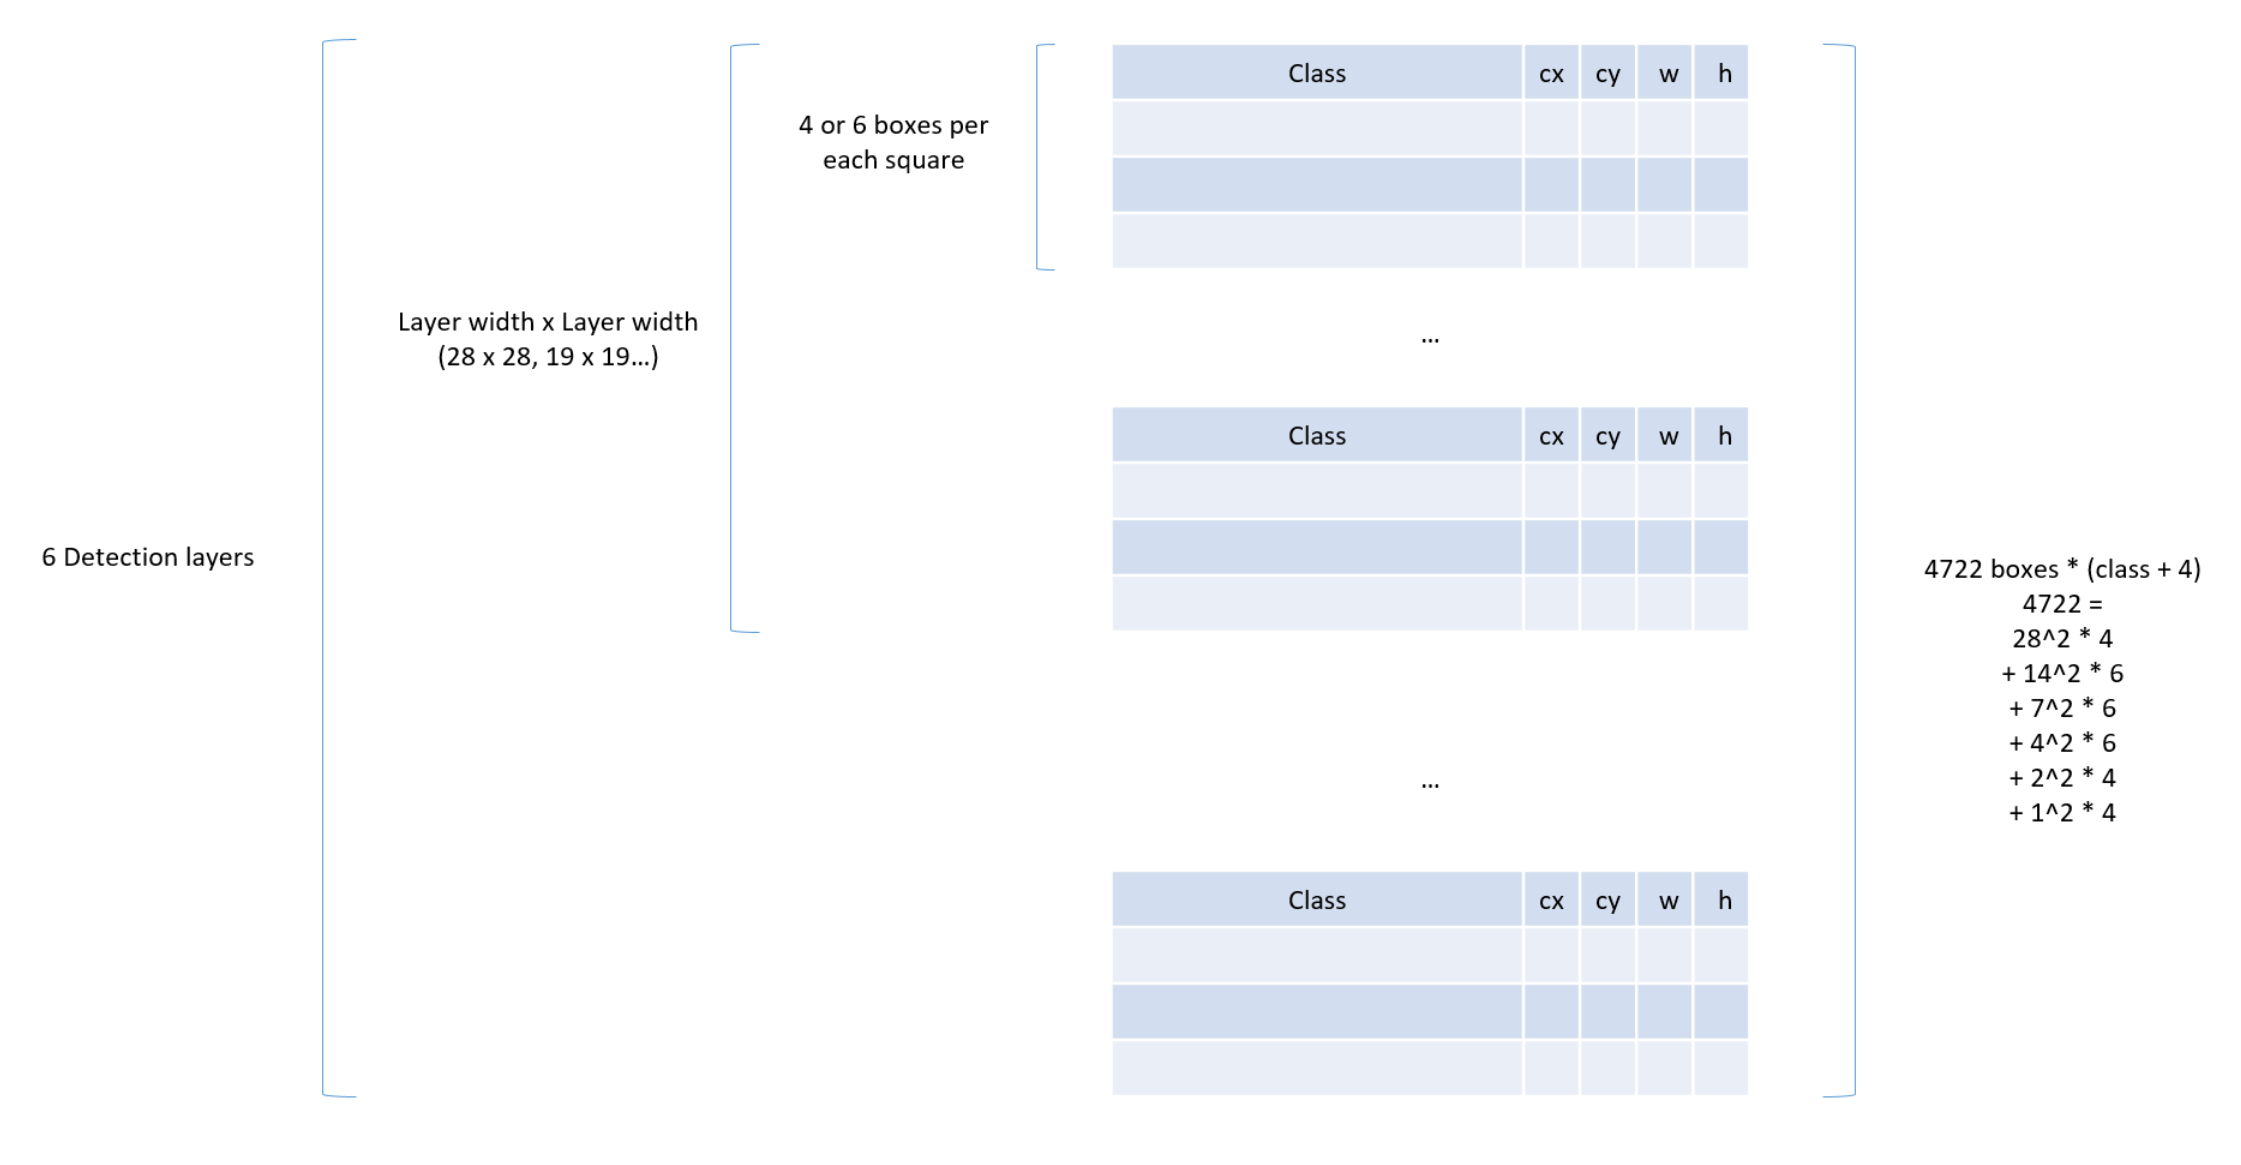
3. 위에서 설명한 calc_iou, match_bipartite_greedy, match_multi 등의 함수를 이용하여 Anchor box중 Ground truth와 많이 겹치는 Box들을 찾는다. 이렇게 찾은 Anchor Box에 class를 지정해주고, 아래의 수식에 따라 loss 계산에 필요한 값들을 정의한다.  d는 anchorbox, g는 ground truth를 의미하며 윗첨자들은 각 좌표값(cx, cy, w, h)에 해당된다.
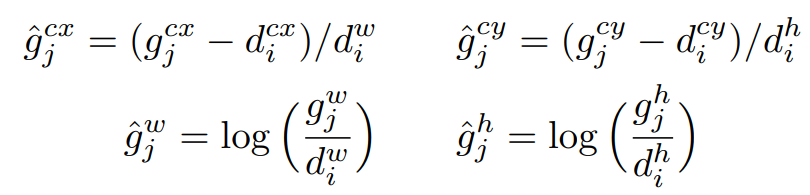

In [11]:
class SSDInputEncodingGenerator(keras.utils.Sequence):
    def __init__(self, 
                 img_height, 
                 img_width, 
                 layer_width, 
                 n_classes, 
                 num_boxes, 
                 s_max, 
                 s_min, 
                 aspect_ratio, 
                 pos_iou_threshold,
                 neg_iou_threshold,
                background_id,
                 images,
                 labels,                 
                batch_size=32):
        #Consider Background class
        self.img_height = img_height
        self.img_width = img_width
        self.n_classes = n_classes + 1  #Add background class
        self.num_boxes = num_boxes  #List of number of boxes in each classifier layer
        self.s_max = s_max # Largest scale of default box
        self.s_min = s_min # Smallest scale of default box
        self.aspect_ratio = aspect_ratio # List of aspect ratios
        self.layer_width = layer_width
        self.pos_iou_threshold = pos_iou_threshold
        self.neg_iou_threshold = neg_iou_threshold
        self.background_id = background_id
        self.batch_size=batch_size
        self.images = images
        self.labels = labels
        self.shuffle = False
        
        self.xmin_random = np.random.randint(self.img_height - 32, size=[50000])
        self.ymin_random = np.random.randint(self.img_height - 32, size=[50000])
        
        self.on_epoch_end()
        
    def convert_image(self, image, label, indexes):
        """
        Convert classification data to object detection data
        Randomly locate image in the middle of black canvas    
        Input
            x: Image, shape: (batch_size, image size, image size, #channels)
            y: label, shape: (batch_size, )
        output
            out_x: Image located in the random location of black canvas, shape: (batch_size, canvas size, canvas size, 3)
            out_y: label and location of corners(xmin,ymin,xmax,ymax), shape: (batch_size, #objects per image, 1+4) #Objects per image = 1

        """
        #get batch size and image size
        orig_image_size = image.shape[-2]
        channels = image.shape[-1]

        #prepare black canvas
        canvas = np.zeros((self.batch_size, self.img_height, self.img_width, channels), dtype=np.int)
        out_y = np.zeros((self.batch_size, 1,5))

        xmin = self.xmin_random[indexes]
        ymin = self.ymin_random[indexes]
        xmax = xmin + orig_image_size
        ymax = ymin + orig_image_size

        for i in range(batch_size):
            canvas[i, xmin[i]:xmax[i], ymin[i]:ymax[i], :] = image[i]

        out_y[:, 0,0] = label[:,0]
        out_y[:, 0, -4:] = np.column_stack([xmin, ymin, xmax, ymax])

        return canvas, out_y
        
    def __getitem__(self, index):
        '''
        Generate one batch of data
        '''
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y
    
    def on_epoch_end(self):
        '''
        Updates indexes after each epoch
        '''
        self.indexes = np.arange(50000)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.images.shape[0] / self.batch_size))
        
    def __data_generation(self, indexes):
        """
        Input: ground truth label,shape: (batch_size, #object per image, 1 + 4)
        Output: y_encoded, shape: (batch_size, sum of grid size of all classifier * num_boxes, n_classes + 4 + 4)
        1. Create y_encoded template: (B, num_boxes, class + 4 + 4) 4 for gt coordinates and 4 for anchor boxes
        2. For each ground truth, calculate iou of gt and anchor boxes
        3. Find the highest matching anchor box per each gt and fill in y_encoded template
        4. Multi object matching
        5. Apply negative iou threshold
        6. Transform into Delta format
        """
        
        images, gt_label = self.convert_image(self.images[indexes], self.labels[indexes], indexes)        
        
        # Make class vector to one hot format
        class_vector = np.eye(self.n_classes)        
        
        for iw in range(len(layer_width)):
            s = s_min + (s_max - s_min) / (len(layer_width) - 1) * (len(layer_width) - iw - 1)
            l = layer_width[iw]            
            num_box = self.num_boxes[iw]            
            box_tensor = np.zeros((l * l * num_box, 4))
            for i in range(layer_width[iw]):                    
                for j in range(layer_width[iw]):
                    for box_idx in range(num_box):
                        box_tensor[(i * l + j) * num_box + box_idx, 0]  = (0.5 + i) / l 
                        box_tensor[(i * l + j) * num_box + box_idx, 1]  = (0.5 + j) / l 
                        
                        if box_idx == 0:
                            s_next = s_min + (s_max - s_min) / (len(layer_width) - 1) * (len(layer_width) - iw)
                            box_tensor[(i * l + j) * num_box + box_idx, 2]  = math.sqrt(aspect_ratio[box_idx]) / l * math.sqrt(s * s_next)
                            box_tensor[(i * l + j) * num_box + box_idx, 3]  = 1 / math.sqrt(aspect_ratio[box_idx]) / l * math.sqrt(s * s_next) 
                        else:                            
                            box_tensor[(i * l + j) * num_box + box_idx, 2]  = math.sqrt(aspect_ratio[box_idx]) / l * s
                            box_tensor[(i * l + j) * num_box + box_idx, 3]  = 1 / math.sqrt(aspect_ratio[box_idx]) / l * s
                        
            box_tensor = convert_coord(box_tensor, type='centroid2corner')
            
            if iw == 0:
                boxes_tensor = box_tensor                
            else:                    
                boxes_tensor = np.concatenate((boxes_tensor, box_tensor), axis = 0)
            
            class_tensor = np.zeros((l * l * num_box , self.n_classes))
            
            if iw == 0:
                classes_tensor = class_tensor                
            else:                    
                classes_tensor = np.concatenate((classes_tensor, class_tensor), axis = 0)
                
        box_class_tensor= np.concatenate((classes_tensor, boxes_tensor, boxes_tensor), axis = 1)
        y_encoded = np.tile(box_class_tensor, (self.batch_size, 1, 1))
        
        y_encoded[:, :, self.background_id] = 1 # All boxes are background boxes by default.
        
    
        for i in range(self.batch_size):
            gt_one_label = gt_label[i]
            m = gt_one_label.shape[0]
            if gt_one_label.shape[0] == 0: continue # If there is no object, skip
            
            #Normalize ground truth
            gt_one_label[:,[-4,-2]] /= self.img_width
            gt_one_label[:,[-3,-1]] /= self.img_height
            
            #FInd the iou of ground truth and all anchor boxes
            similarities = calc_iou(gt_one_label[:,-4:], y_encoded[i, :, -4:])            
            
            #Find the highest matching anchor box per each ground truth boxes
            matches = match_bipartite_greedy(similarities)
            
            #Convert ground truth class label to one hot encoding            
            gt_class = np.array(gt_one_label[:,0], dtype=np.int)
                        
            #Fill in y_encoded
            y_encoded[i, matches, :self.n_classes] = class_vector[gt_class]
            y_encoded[i, matches, -8:-4] = gt_one_label[:,1:]
            
            #Set the matched anchor boxes to 0 to indicate they are matched before multi object matching
            similarities[:,matches] = 0
            
            
            #Multi object matching
            #Similar process to bipartite matching
            matches_anchor, matches_gt = match_multi(similarities, threshold=self.pos_iou_threshold)            
            
            if len(matches_gt) > 0:            

                y_encoded[i, matches_anchor, :self.n_classes] = class_vector[gt_class[matches_gt]]           
                y_encoded[i, matches_anchor, -8:-4] = gt_one_label[matches_gt,1:]

                #Set the matched anchor boxes to 0 to indicate they are matched before applying negative iou threshold
                similarities[:,matches_anchor] = 0
            
            #All background boxes whose iou are greater than neg_iou_threshold 
            # are set to neutral(neither background nor class)
            max_bg_similarities = np.amax(similarities, axis = 0)
            neutral_boxes = np.nonzero(max_bg_similarities >= self.neg_iou_threshold)[0]
            y_encoded[i, neutral_boxes, self.background_id] = 0
        
        #Convert coordinate from corner 2 centroid
        y_encoded[:,:,:-4] = convert_coord(y_encoded[:,:,:-4], type='corner2centroid')
        #print(y_encoded[0,0])
        y_encoded = convert_coord(y_encoded, type='corner2centroid')        
        #print(y_encoded[0,0])
        
        y_encoded[:,:,[-8, -7]] -= y_encoded[:,:,[-4, -3]] # (cx(gt) - cx(d_box)) # (cy(gt) - cy(d_box))
        y_encoded[:,:,[-8, -7]] /= y_encoded[:,:,[-2, -1]] # (cx(gt) - cx(d_box)) / w(d_box) # (cy(gt) - cy(d_box)) / h(d_box)
        y_encoded[:,:,[-6, -5]] = np.log(y_encoded[:,:,[-6, -5]] / y_encoded[:,:,[-2, -1]]) #log(w(gt) / w(d_box)) #log(h(gt) / h(d_box))
                  
        return images, y_encoded

In [12]:
ssd_input_gen = SSDInputEncodingGenerator(IMG_SIZE, 
                 IMG_SIZE, 
                 layer_width=layer_width, 
                 n_classes=n_classes, 
                 num_boxes=num_boxes, 
                 s_max=s_max, 
                 s_min=s_min, 
                 aspect_ratio=aspect_ratio, 
                 pos_iou_threshold=pos_iou_threshold,
                 neg_iou_threshold=neg_iou_threshold,
                 background_id=10,
                 images=x_train,
                 labels=y_train,                 
                batch_size=32)

In [13]:
import matplotlib.patches as patches

def show(image, label, img_width, img_height):
    
    fig,ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(image)
    gt_boxes = np.argwhere(label[:,10]==0)
    print(gt_boxes)
    for match in gt_boxes:
        box = label[match[0],-4:]
        xmin = box[0] - box[2]/2
        ymin = box[1] - box[3]/2
        w = box[2]
        h = box[3]        
        xmin *= img_width
        ymin *= img_height
        w *= img_width
        h *= img_height        
        
        rect = patches.Rectangle((ymin,xmin),w, h,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect)
    plt.show()
    

In [14]:
image, label = next(iter(ssd_input_gen))

[[4682]]


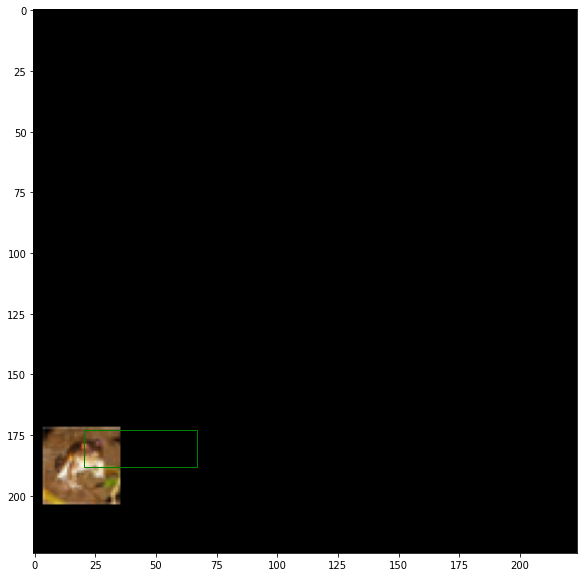

In [15]:
show(image[0], label[0], IMG_SIZE, IMG_SIZE)

## Construct a model

이제 모델을 구성할 차례이다. 지난 실습때 구성한 MobiletNet V2를 기본으로 하여 Detection Layer들을 추가해 주는 방식으로 진행한다. 아래 두 함수(_make_divisible, _inverted_res_block)는 MobileNet V2와 동일한 Helper Function이다.

In [16]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor) # 더 가까운 divisor의 배수로 올림 4,5,6,7,8,9,10,11 -> 8, 12~19 -> 16 ...
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [17]:
def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    #Get the channel axis and the input channel size
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
    in_channels = backend.int_shape(inputs)[channel_axis]
    
    pointwise_conv_filters = int(alpha * filters)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8) # Make sure the output filter size is the multiple of 8
    
    #Set the prefix
    prefix = 'block_{}_'.format(block_id)
    
    x = inputs
    
    #Expansion block    
    if block_id: # No expansion for block 0
        x = layers.Conv2D(filters = expansion * in_channels, kernel_size = 1, strides = 1, padding='same',
                          use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                          name=prefix + 'expand')(x)
        x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001, 
                                      name=prefix + 'expand_BN')(x)
        x = layers.ReLU(6, name=prefix + 'expand_relu')(x)
    else: 
        prefix = 'expanded_conv_'
    
    
    #Depthwise convolution
    #if stride == 2:
        #Adjust zero paddings for strides, when input hieght and width are odd add (1,1,1,1) padding / when even, add (0,1,0,1)
        #x = layers.ZeroPadding2D(padding=correct_pad(x, 3),
        #                         name=prefix + 'pad')(x)
    
    x = layers.DepthwiseConv2D(kernel_size = 3, strides = stride, 
                               #padding='same' if stride == 1 else 'valid',
                               padding='same',
                               use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                               name=prefix + 'depthwise')(x)
    x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001,
                                 name=prefix + 'depthwise_BN')(x)
    x = layers.ReLU(6, name=prefix + 'relu')(x)
    
    #Pointwise convolution(Bottleneck)
    x = layers.Conv2D(filters = pointwise_filters, kernel_size = 1, strides = 1, padding='same',
                      use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                      name=prefix + 'project')(x)
    x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001,
                                 name=prefix + 'project_BN')(x)
    
    #Inverted residual only when valid(Input size = output_size)
    if in_channels == pointwise_filters and stride == 1:
        return layers.add([inputs, x])
    return x

추후 좌표 복원의 편의를 위하여 각 Predicted box별로 Default anchor box의 좌표들을 붙여주는데, 아래는 이를 생성하기 위한 코드이다. Default anchor box의 좌표 생성 과정은 Training label 생성 과정과 동일하다.

In [18]:
from tensorflow.keras.layers import Layer, InputSpec

class AnchorBoxes(Layer):    
    def __init__(self, layer_width, n_classes, num_boxes,
                 s_max, s_min, aspect_ratio, index, **kwargs):             
        self.layer_width = layer_width
        self.n_classes = n_classes
        self.num_boxes = num_boxes
        self.s_max = s_max
        self.s_min = s_min
        self.aspect_ratio = aspect_ratio
        self.index = index    
        super(AnchorBoxes, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(AnchorBoxes, self).build(input_shape)
    
    def compute_output_shape(self, input_shape):
        if K.image_dim_ordering() == 'tf':
            batch_size, feature_map_height, feature_map_width, feature_map_channels = input_shape
       
        return (batch_size, feature_map_height*feature_map_width*self.n_boxes, 4)
    
    def get_config(self):
        config = {
            'layer_width': list(self.layer_width),                        
            'n_classes': self.n_classes,
            'num_boxes': self.num_boxes,
            's_max': self.s_max,
            's_min': self.s_min,
            'aspect_ratio': list(self.aspect_ratio)            
        }
        base_config = super(AnchorBoxes, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, x, mask=None):
        s = self.s_min + (self.s_max - self.s_min) / (len(self.layer_width) - 1) * (len(self.layer_width) - self.index - 1)
        l = self.layer_width[self.index]            
        num_box = self.num_boxes[self.index]            
        box_tensor = np.zeros((l * l * num_box, 4))
        for i in range(self.layer_width[self.index]):                    
            for j in range(self.layer_width[self.index]):
                for box_idx in range(num_box):
                    box_tensor[(i * l + j) * num_box + box_idx, 0]  = (0.5 + i) / l 
                    box_tensor[(i * l + j) * num_box + box_idx, 1]  = (0.5 + j) / l 

                    if box_idx == 0:
                        s_next = self.s_min + (self.s_max - self.s_min) / (len(self.layer_width) - 1) * (len(self.layer_width) - self.index)
                        box_tensor[(i * l + j) * num_box + box_idx, 2]  = math.sqrt(self.aspect_ratio[box_idx]) / l * math.sqrt(s * s_next)
                        box_tensor[(i * l + j) * num_box + box_idx, 3]  = 1 / math.sqrt(self.aspect_ratio[box_idx]) / l * math.sqrt(s * s_next)        
                    else:                            
                        box_tensor[(i * l + j) * num_box + box_idx, 2]  = math.sqrt(self.aspect_ratio[box_idx]) / l * s
                        box_tensor[(i * l + j) * num_box + box_idx, 3]  = 1 / math.sqrt(self.aspect_ratio[box_idx]) / l * s
    
  
        box_tensor = np.expand_dims(box_tensor, axis = 0)
        return tf.tile(tf.constant(box_tensor, dtype=tf.float32), (tf.shape(x)[0],1,1))

MobileNet V2 모델을 변형하여 MobileNetV2SSD로 만들어 주자. 3번째 Bottleneck block을 통과한 뒤 첫번째 Detection Layer(가장 촘촘한 격자)가 연결되도록 해주고, 4번째 Bottleneck block을 통과한 뒤 두번째 Detection Layer가 연결되도록 해주자.3~6번째 Detection layer는 2번째 Detection Layer로부터 차례로 연결되도록 구성한다. <br>
**Note:**
* Classification과 Localization을 위한 Layer를 따로 생성한 뒤, 나중에 Concatenate를 통해 합쳐주는 방식으로 구성한다. 하나의 layer로 생성하게되면, Classification에 Softmax를 적용하기가 어렵다.
* 위에 정의된 Anchor Box 함수를 이용하여 Default Anchor Box의 좌표를 상수로 입력해 둔다. 나중에 좌표 복원시에 용이하게 사용할 수 있다.

In [19]:
def MobileNetV2SSD(input_shape,
                classes,
                layer_width,
                num_boxes,
                alpha=1.0):
    
    
    inputs = layers.Input(shape=input_shape)
    
    first_block_filters = _make_divisible(32 * alpha, 8)
    # first conv layer: 224x224x3 -> 112x112x32
    x = layers.Conv2D(first_block_filters, kernel_size=3, strides=(2, 2), padding='same',  use_bias=False, 
                      bias_initializer='zeros',  kernel_regularizer=regularizers.l2(0.00004),
                      name='Conv1')(inputs)
    
    x = layers.BatchNormalization(
      axis=-1, epsilon=1e-3, momentum=0.999, name='bn_Conv1')(x)
    
    x = layers.ReLU(6., name='Conv1_relu')(x)
    
    
    # inverted residual blocks
    # 1st bottleneck block: 112x112x32 -> 112x112x16
    x = _inverted_res_block(
      x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    # 2nd bottleneck block: 112x112x16 -> 56x56x24
    x = _inverted_res_block(
      x, filters=24, alpha=alpha, stride=2, expansion=6, block_id=1)
    x = _inverted_res_block(
      x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2)

    # 3rd bottleneck block: 56x56x24 -> 28x28x32
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5)

    classifier_1_conf = layers.Conv2D(num_boxes[0] * classes, kernel_size = 3, padding='same', use_bias=False, name='classifier_1_conf')(x)
    classifier_1_loc = layers.Conv2D(num_boxes[0] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_1_loc')(x)
    
    # 4th bottleneck block: 28x28x32 -> 14x14x64
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=7)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=8)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=9)
    
    classifier_2_conf = layers.Conv2D(num_boxes[1] * classes, kernel_size = 3, padding='same', use_bias=False, name='classifier_2_conf')(x)
    classifier_2_loc = layers.Conv2D(num_boxes[1] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_2_loc')(x)

    x = layers.Conv2D(256, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) #7x7
    
    classifier_3_conf = layers.Conv2D(num_boxes[2] * classes, kernel_size = 3, padding='same', use_bias=False, name='classifier_3_conf')(x)
    classifier_3_loc = layers.Conv2D(num_boxes[2] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_3_loc')(x)
    
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 4x4
    
    classifier_4_conf = layers.Conv2D(num_boxes[3] * classes, kernel_size = 3, padding='same', use_bias=False, name='classifier_4_conf')(x)
    classifier_4_loc = layers.Conv2D(num_boxes[3] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_4_loc')(x)
    
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 2x2
    
    classifier_5_conf = layers.Conv2D(num_boxes[4] * classes, kernel_size = 3, padding='same', use_bias=False, name='classifier_5_conf')(x)
    classifier_5_loc = layers.Conv2D(num_boxes[4] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_5_loc')(x)
    
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 1x1

    classifier_6_conf = layers.Conv2D(num_boxes[5] * classes, kernel_size = 3, padding='same', use_bias=False, name='classifier_6_conf')(x)
    classifier_6_loc = layers.Conv2D(num_boxes[5] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_6_loc')(x)
    
    #Classification tensors
    classifier_1_conf = layers.Reshape((layer_width[0]*layer_width[0]*num_boxes[0], classes))(classifier_1_conf)
    classifier_2_conf = layers.Reshape((layer_width[1]*layer_width[1]*num_boxes[1], classes))(classifier_2_conf)
    classifier_3_conf = layers.Reshape((layer_width[2]*layer_width[2]*num_boxes[2], classes))(classifier_3_conf)
    classifier_4_conf = layers.Reshape((layer_width[3]*layer_width[3]*num_boxes[3], classes))(classifier_4_conf)
    classifier_5_conf = layers.Reshape((layer_width[4]*layer_width[4]*num_boxes[4], classes))(classifier_5_conf)
    classifier_6_conf = layers.Reshape((layer_width[5]*layer_width[5]*num_boxes[5], classes))(classifier_6_conf)
    
    conf_layers = layers.concatenate([classifier_1_conf, classifier_2_conf, classifier_3_conf, 
                                      classifier_4_conf, classifier_5_conf, classifier_6_conf], axis = 1)
    
    #Apply softmax
    conf_layers_softmax = layers.Activation('softmax')(conf_layers)
    
    #Localization tensors
    classifier_1_loc = layers.Reshape((layer_width[0]*layer_width[0]*num_boxes[0], 4))(classifier_1_loc)
    classifier_2_loc = layers.Reshape((layer_width[1]*layer_width[1]*num_boxes[1], 4))(classifier_2_loc)
    classifier_3_loc = layers.Reshape((layer_width[2]*layer_width[2]*num_boxes[2], 4))(classifier_3_loc)
    classifier_4_loc = layers.Reshape((layer_width[3]*layer_width[3]*num_boxes[3], 4))(classifier_4_loc)
    classifier_5_loc = layers.Reshape((layer_width[4]*layer_width[4]*num_boxes[4], 4))(classifier_5_loc)
    classifier_6_loc = layers.Reshape((layer_width[5]*layer_width[5]*num_boxes[5], 4))(classifier_6_loc)
    
    loc_layers = layers.concatenate([classifier_1_loc, classifier_2_loc, classifier_3_loc, 
                                      classifier_4_loc, classifier_5_loc, classifier_6_loc], axis = 1)

    
    #Default anchor box tensors, They are constant and NOT trained !!
    dbox_1 = AnchorBoxes(layer_width=layer_width, n_classes=classes, num_boxes=num_boxes, 
                         s_max=s_max, s_min=s_min, aspect_ratio=aspect_ratio, index = 0)(classifier_1_loc)    
    
    dbox_2 = AnchorBoxes(layer_width=layer_width, n_classes=classes, num_boxes=num_boxes, 
                         s_max=s_max, s_min=s_min, aspect_ratio=aspect_ratio, index = 1)(classifier_2_loc)    
    
    dbox_3 = AnchorBoxes(layer_width=layer_width, n_classes=classes, num_boxes=num_boxes, 
                         s_max=s_max, s_min=s_min, aspect_ratio=aspect_ratio, index = 2)(classifier_3_loc)    
    
    dbox_4 = AnchorBoxes(layer_width=layer_width, n_classes=classes, num_boxes=num_boxes, 
                         s_max=s_max, s_min=s_min, aspect_ratio=aspect_ratio, index = 3)(classifier_4_loc)    
    
    dbox_5 = AnchorBoxes(layer_width=layer_width, n_classes=classes, num_boxes=num_boxes, 
                         s_max=s_max, s_min=s_min, aspect_ratio=aspect_ratio, index = 4)(classifier_5_loc)
    
    dbox_6 = AnchorBoxes(layer_width=layer_width, n_classes=classes, num_boxes=num_boxes, 
                         s_max=s_max, s_min=s_min, aspect_ratio=aspect_ratio, index = 5)(classifier_6_loc)
    
    dbox_layers = layers.concatenate([dbox_1, dbox_2, dbox_3, dbox_4, dbox_5, dbox_6], axis = 1)
    
    
    #Concatenate Classification tensor, Localization tensor and Default anchor box tensor.
    detections = layers.concatenate([conf_layers_softmax, loc_layers, dbox_layers], axis=-1)

    outputs = detections
    
    return Model(inputs=inputs, outputs=outputs)
    

In [20]:
model = MobileNetV2SSD((IMG_SIZE, IMG_SIZE, 3), n_classes+1, layer_width, num_boxes, alpha=1.0)

In [21]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________________

## Loss function
SSD Loss는 Tensorflow에서 기본적으로 제공하지 않으므로, 직접 생성해 주어야 한다.
* Localization loss: smooth L1 loss를 사용한다. 1보다 작을 때는 L2 Loss를, 1보다 클 때는 L1 Loss를 사용한다. Positive box에만 적용한다.(Ground truth와 매칭된 anchor box)
* Confidence loss: Cross entropy loss를 사용한다. 다만 Positive box와 Negative box를 구분하여 각각에 대한 Loss를 따로 구하고 합쳐준다. 

In [22]:
class SSDLoss():
    def __init__(self, n_classes, background_id, neg_pos_ratio=3, n_neg_min=0, alpha=1.0):
        self.neg_pos_ratio = neg_pos_ratio
        self.n_neg_min = 0
        self.alpha = alpha
        self.background_id = background_id
        self.n_classes = n_classes
        
    def smoothL1Loss(self, y_true, y_pred):
        """
        y_true: ground truth localization tensor, shape: (batch_size, num_boxes, 4)
        y_pred: predicted localization tensor, shape: (batch_size, num_boxes, 4)
        """
        diff = tf.abs(y_pred - y_true)
        l1_loss = tf.where(tf.less(diff, 1), 0.5 * diff ** 2, diff - 0.5)

        return tf.reduce_sum(l1_loss, axis=-1)
        
    def compute_loss(self, y_true, y_pred):    
        """
        y_true: (batch_size, # boxes, n_classes + 4)
        y_pred: (batch_size, # boxes, n_classes + 4)
        """
        
        #self.neg_pos_ratio = tf.constant(self.neg_pos_ratio, dtype=tf.int32)
        #self.n_neg_min = tf.constant(self.n_neg_min, dtype=tf.int32)
        #self.alpha  = tf.constant(self.alpha, dtype=tf.float32)
        
        #Get the size of tensor
        batch_size = tf.shape(y_true)[0]
        n_boxes = tf.shape(y_pred)[1]
                
        #classification loss
        class_pred = tf.maximum(y_pred[:,:,:n_classes], 1e-15)
        class_true = y_true[:,:,:n_classes]

        classification_loss = -tf.cast(tf.reduce_sum(class_true * tf.math.log(class_pred), axis = -1), dtype=tf.float32)  # (batch_size, n_boxes)
        
        negatives = y_true[:,:,self.background_id] # Class is background, (batch_size, n_boxes)
        positives = tf.cast(tf.reduce_max(y_true[:,:,:n_classes-1], axis=-1), dtype=tf.float32) # Class is NOT background, (batch_size, n_boxes)       

        n_positives = tf.cast(tf.reduce_sum(positives), dtype=tf.float32) # number of positive boxes, single number
        
        # Loss for positive boxes
        pos_class_loss = tf.reduce_sum(classification_loss * positives, axis=-1) # (batch_size)  
        
        #localization loss
        loc_pred = y_pred[:,:,n_classes:-4]
        loc_true = y_true[:,:,n_classes:-4]
        loc_loss = tf.cast(self.smoothL1Loss(loc_true, loc_pred), dtype=tf.float32) # (batch_size, n_boxes)       
        
        # Include only positive boxes in calculating localization loss
        loc_loss = tf.reduce_sum(positives * loc_loss, axis=-1) #(batch_size)     
        
        
        # Loss for negative boxes
        neg_class_loss_all = classification_loss * negatives #(batch_size, n_boxes)
        n_neg_losses = tf.math.count_nonzero(neg_class_loss_all, dtype=tf.int32) # The number of nonzero entries in neg_class_loss_all
        
        # Keep the number of negative boxes between n_neg_min and neg_pos_ratio * positive_boxes        
        n_negative_keep = tf.minimum(tf.maximum(self.neg_pos_ratio * tf.cast(n_positives, dtype=tf.int32), self.n_neg_min), n_neg_losses)
        
        def f1():
            return tf.zeros([batch_size])
        
        def f2():
            #Resahpe neg_class_loss_all to 1d array
            neg_class_loss_all_1D = tf.reshape(neg_class_loss_all, [-1])

            # Find top 'n_negative_keep' boxes from neg_class_loss_all_1D
            values, indices = tf.nn.top_k(neg_class_loss_all_1D, k=n_negative_keep, sorted=False)

            #Then create a mask for negative boxes: For selected box above, set them as 1
            negatives_keep = tf.scatter_nd(indices=tf.expand_dims(indices, axis=1),
                                           updates=tf.ones_like(indices, dtype=tf.int32),
                                           shape=tf.shape(neg_class_loss_all_1D))
            negatives_keep = tf.cast(tf.reshape(negatives_keep, [batch_size, n_boxes]), dtype=tf.float32)            

            #Finally compute negative loss
            neg_class_loss = tf.reduce_sum(classification_loss * negatives_keep, axis=-1) #(batch_size)
            
            return neg_class_loss
        
        neg_class_loss = tf.cond(tf.equal(n_neg_losses, tf.constant(0)), f1, f2)   
        
        
        class_loss = pos_class_loss  + neg_class_loss
        
        #Combine localization and classification loss, divide by matched default box(n_positives)
        total_loss = (class_loss + loc_loss * self.alpha) / tf.maximum(1.0, n_positives)
        
        # We divided by n_positives - # of all matched default boxes of "a batch"
        # Since keras divides by the size of batch, it is double division
        # To adjust this, we multiply by batch_size
        total_loss = total_loss * tf.cast(batch_size, dtype=tf.float32)
        
        return total_loss

## Model compile and Training
이제 모델을 컴파일하고 트레이닝하자. CallBack 함수를 지정하면 필요한 대로 트레이닝 옵션들을 추가할 수 있다.

In [23]:
#decay could be applied using Learning rate scheduler
def decay(epoch):
    return 0.045 * (0.98 **(epoch-1))

In [24]:
callbacks = []
"""
#TensorBoard로 훈련 성과를 보고 싶은 경우
callbacks.append(TensorBoard(log_dir=log_dir, histogram_freq=1))
"""

#Checkpoint설정
checkpoint_dir = './training_checkpoints'
model_cp_path = os.path.join(checkpoint_dir, "ckpt_{epoch}")
callbacks.append(tf.keras.callbacks.ModelCheckpoint(model_cp_path, save_weights_only=True))

"""
#Learning rate 스케쥴 설정
callbacks.append(LearningRateScheduler(decay))
"""
#General logs on csv
callbacks.append(CSVLogger(model_csv_path)) 

모델을 컴파일 하고 트레이닝을 시작하자.<br>
* Optimizer: Adam을 사용한다.
* Loss: 위에서 정의한 SSDLoss를 사용하자.

In [25]:
ssd_loss = SSDLoss(n_classes = n_classes, background_id=10, neg_pos_ratio=3, alpha=1)
model.compile(loss=ssd_loss.compute_loss,     
              optimizer=tf.keras.optimizers.Adam())
              #optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0))
              

In [26]:
history = model.fit(ssd_input_gen,
              #datagen.flow(train_images, train_labels, batch_size=batch_size),
              #steps_per_epoch=math.ceil(len(train_images) / batch_size),
              epochs=200,
              verbose=1,
              callbacks=callbacks)
              #validation_data=(val_images, val_labels))

Epoch 1/200
1562/1562 [==============================] - 200s 128ms/step - loss: 2.3167
Epoch 2/200
1562/1562 [==============================] - 202s 129ms/step - loss: 1.9434
Epoch 3/200
1562/1562 [==============================] - 203s 130ms/step - loss: 1.8242
Epoch 4/200
1562/1562 [==============================] - 203s 130ms/step - loss: 1.7341
Epoch 5/200
1562/1562 [==============================] - 204s 131ms/step - loss: 1.6615
Epoch 6/200
1562/1562 [==============================] - 203s 130ms/step - loss: 1.5728
Epoch 7/200
1562/1562 [==============================] - 200s 128ms/step - loss: 1.4756
Epoch 8/200
1562/1562 [==============================] - 200s 128ms/step - loss: 1.3936
Epoch 9/200
1562/1562 [==============================] - 199s 127ms/step - loss: 1.3228
Epoch 10/200
1562/1562 [==============================] - 199s 127ms/step - loss: 1.2613
Epoch 11/200
1562/1562 [==============================] - 200s 128ms/step - loss: 1.2114
Epoch 12/200
1562/1562 [======

1562/1562 [==============================] - 199s 127ms/step - loss: 0.2834
Epoch 91/200
1562/1562 [==============================] - 199s 127ms/step - loss: 0.2899
Epoch 92/200
1562/1562 [==============================] - 199s 127ms/step - loss: 0.2649
Epoch 93/200
1562/1562 [==============================] - 199s 127ms/step - loss: 0.2922
Epoch 94/200
1562/1562 [==============================] - 199s 128ms/step - loss: 0.2844
Epoch 95/200
1562/1562 [==============================] - 199s 128ms/step - loss: 0.3000
Epoch 96/200
1562/1562 [==============================] - 200s 128ms/step - loss: 0.2875
Epoch 97/200
1562/1562 [==============================] - 199s 128ms/step - loss: 0.2861
Epoch 98/200
1562/1562 [==============================] - 200s 128ms/step - loss: 0.2697
Epoch 99/200
1562/1562 [==============================] - 199s 127ms/step - loss: 0.2941
Epoch 100/200
1562/1562 [==============================] - 199s 127ms/step - loss: 0.2758
Epoch 101/200
1562/1562 [========

1562/1562 [==============================] - 199s 128ms/step - loss: 0.2622
Epoch 182/200
1562/1562 [==============================] - 199s 128ms/step - loss: 0.2657
Epoch 183/200
1562/1562 [==============================] - 199s 128ms/step - loss: 0.2817
Epoch 184/200
1562/1562 [==============================] - 199s 127ms/step - loss: 0.2605
Epoch 185/200
1562/1562 [==============================] - 200s 128ms/step - loss: 0.2814
Epoch 186/200
1562/1562 [==============================] - 200s 128ms/step - loss: 0.2372
Epoch 187/200
1562/1562 [==============================] - 200s 128ms/step - loss: 0.2688
Epoch 188/200
1562/1562 [==============================] - 200s 128ms/step - loss: 0.2691
Epoch 189/200
1562/1562 [==============================] - 200s 128ms/step - loss: 0.2553
Epoch 190/200
1562/1562 [==============================] - 200s 128ms/step - loss: 0.2777
Epoch 191/200
1562/1562 [==============================] - 200s 128ms/step - loss: 0.2606
Epoch 192/200
1562/1562 

In [66]:
y_pred = model.predict(image)

In [67]:
y_pred[0,3742]

array([2.2974433e-01, 1.4025801e-03, 1.2960234e-01, 3.4834664e-02,
       3.9989567e-01, 4.8603588e-03, 7.6101378e-02, 3.9120098e-03,
       1.1961476e-01, 1.7987169e-05, 1.3979609e-05, 5.1551789e-02,
       2.1834153e-01, 8.8846701e-01, 9.1579866e-01, 5.3571427e-01,
       2.5000000e-01, 5.9074495e-02, 5.9074495e-02], dtype=float32)

In [68]:
np.argwhere((y_pred[0,list(range(y_pred.shape[1])),np.argmax(y_pred[0,:,:10], axis=1)]>0.9)==True)

array([[ 463],
       [ 467],
       [ 571],
       [ 572],
       [ 573],
       [ 575],
       [ 576],
       [ 578],
       [ 579],
       [ 581],
       [ 583],
       [ 676],
       [ 682],
       [ 684],
       [ 685],
       [ 686],
       [ 688],
       [ 691],
       [ 692],
       [ 693],
       [ 695],
       [ 699],
       [ 701],
       [ 789],
       [ 792],
       [ 793],
       [ 798],
       [ 800],
       [ 801],
       [ 802],
       [ 803],
       [ 804],
       [ 809],
       [ 813],
       [ 909],
       [ 911],
       [ 912],
       [ 913],
       [ 914],
       [ 916],
       [ 917],
       [ 919],
       [ 922],
       [ 924],
       [1019],
       [1021],
       [1026],
       [1029],
       [1031],
       [1037],
       [1041],
       [1124],
       [1128],
       [1132],
       [1133],
       [1137],
       [1146],
       [1147],
       [1150],
       [1153],
       [1247],
       [1248],
       [1249],
       [1357],
       [1358],
       [1359],
       [13

In [69]:
def _greedy_nms(predictions, iou_threshold=0.45):
    '''
    Non-maximum suppression.
    '''
    boxes_left = np.copy(predictions)
    maxima = [] # This is where we store the boxes that make it through the non-maximum suppression
    while boxes_left.shape[0] > 0: # While there are still boxes left to compare...
        maximum_index = np.argmax(boxes_left[:,0]) # ...get the index of the next box with the highest confidence...
        maximum_box = np.copy(boxes_left[maximum_index]) # ...copy that box and...
        maxima.append(maximum_box) # ...append it to `maxima` because we'll definitely keep it
        boxes_left = np.delete(boxes_left, maximum_index, axis=0) # Now remove the maximum box from `boxes_left`
        if boxes_left.shape[0] == 0: break # If there are no boxes left after this step, break. Otherwise...
        similarities = calc_iou(boxes_left[:,1:],np.expand_dims(maximum_box[1:],axis=0)) # ...compare (IoU) the other left over boxes to the maximum box...
        boxes_left = boxes_left[(similarities <= iou_threshold)[:,0]] # ...so that we can remove the ones that overlap too much with the maximum box
    return np.array(maxima)

In [70]:
def decode_detections(y_pred,
                      n_classes,
                      confidence_thresh=0.01,
                      iou_threshold=0.45,
                      top_k=200,                      
                      img_height=None,
                      img_width=None,
                      background_id=10):
    # 1: Convert the box coordinates from the predicted anchor box offsets to predicted absolute coordinates

    y_pred_decoded_raw = np.copy(y_pred[:,:,:-4]) # Slice out the classes and the four offsets, throw away the anchor coordinates and variances, resulting in a tensor of shape `[batch, n_boxes, n_classes + 4 coordinates]`

    # exp(ln(w(pred)/w(anchor)) / w_variance * w_variance) == w(pred) / w(anchor), exp(ln(h(pred)/h(anchor)) / h_variance * h_variance) == h(pred) / h(anchor)
    y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]]) 
    
    # (w(pred) / w(anchor)) * w(anchor) == w(pred), (h(pred) / h(anchor)) * h(anchor) == h(pred)
    y_pred_decoded_raw[:,:,[-2,-1]] *= y_pred[:,:,[-2,-1]] 
    
    # (delta_cx(pred) / w(anchor) / cx_variance) * cx_variance * w(anchor) == delta_cx(pred), (delta_cy(pred) / h(anchor) / cy_variance) * cy_variance * h(anchor) == delta_cy(pred)
    y_pred_decoded_raw[:,:,[-4,-3]] *= y_pred[:,:,[-2,-1]] 
    
    # delta_cx(pred) + cx(anchor) == cx(pred), delta_cy(pred) + cy(anchor) == cy(pred)
    y_pred_decoded_raw[:,:,[-4,-3]] += y_pred[:,:,[-4,-3]] 
    print(y_pred_decoded_raw[:,4684])
    y_pred_decoded_raw = convert_coord(y_pred_decoded_raw, type='centroid2corner')
    print(y_pred_decoded_raw[:,4684])
    
    # 2: If the model predicts normalized box coordinates and they are supposed to be converted back to absolute coordinates, do that   
    y_pred_decoded_raw[:,:,[-4,-2]] *= img_width # Convert xmin, xmax back to absolute coordinates
    y_pred_decoded_raw[:,:,[-3,-1]] *= img_height # Convert ymin, ymax back to absolute coordinates

    # 3: Apply confidence thresholding and non-maximum suppression per class

    #n_classes = y_pred_decoded_raw.shape[-1] - 4 # The number of classes is the length of the last axis minus the four box coordinates

    y_pred_decoded = [] # Store the final predictions in this list
    for batch_item in y_pred_decoded_raw: # `batch_item` has shape `[n_boxes, n_classes + 4 coords]`
        pred = [] # Store the final predictions for this batch item here        
        for class_id in range(n_classes): # For each class except the background class 
            if class_id == background_id: continue
            single_class = batch_item[:,[class_id, -4, -3, -2, -1]] # ...keep only the confidences for that class, making this an array of shape `[n_boxes, 5]` and...
            threshold_met = single_class[single_class[:,0] > confidence_thresh] # ...keep only those boxes with a confidence above the set threshold.
            if threshold_met.shape[0] > 0: # If any boxes made the threshold...
                maxima = _greedy_nms(threshold_met, iou_threshold=iou_threshold) # ...perform NMS on them.
                maxima_output = np.zeros((maxima.shape[0], maxima.shape[1] + 1)) # Expand the last dimension by one element to have room for the class ID. This is now an arrray of shape `[n_boxes, 6]`
                maxima_output[:,0] = class_id # Write the class ID to the first column...
                maxima_output[:,1:] = maxima # ...and write the maxima to the other columns...
                pred.append(maxima_output) # ...and append the maxima for this class to the list of maxima for this batch item.
        # Once we're through with all classes, keep only the `top_k` maxima with the highest scores
        if pred: # If there are any predictions left after confidence-thresholding...
            pred = np.concatenate(pred, axis=0)
            if top_k != 'all' and pred.shape[0] > top_k: # If we have more than `top_k` results left at this point, otherwise there is nothing to filter,...
                top_k_indices = np.argpartition(pred[:,1], kth=pred.shape[0]-top_k, axis=0)[pred.shape[0]-top_k:] # ...get the indices of the `top_k` highest-score maxima...
                pred = pred[top_k_indices] # ...and keep only those entries of `pred`...
        else:
            pred = np.array(pred) # Even if empty, `pred` must become a Numpy array.
        y_pred_decoded.append(pred) # ...and now that we're done, append the array of final predictions for this batch item to the output list

    return y_pred_decoded

In [71]:
y_decoded = decode_detections(np.expand_dims(y_pred[0], axis=0),10, confidence_thresh=0.9,
                      iou_threshold=0.45,
                      top_k=100,                      
                      img_height=IMG_SIZE,
                      img_width=IMG_SIZE,
                 background_id=10)

[[4.04940266e-03 1.41811080e-03 4.93940204e-01 1.01598546e-01
  1.71797816e-02 4.55252156e-02 3.25365990e-01 9.81439371e-03
  1.10353413e-03 2.10029134e-06 2.77040294e-06 8.59029591e-01
  3.62169802e-01 1.54461056e-01 1.46323085e-01]]
[[4.04940266e-03 1.41811080e-03 4.93940204e-01 1.01598546e-01
  1.71797816e-02 4.55252156e-02 3.25365990e-01 9.81439371e-03
  1.10353413e-03 2.10029134e-06 2.77040294e-06 7.81799078e-01
  2.89008260e-01 9.36260104e-01 4.35331345e-01]]


In [72]:
import matplotlib.patches as patches

def show(image, label, prediction):
    
    fig,ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(image)
    gt_boxes = np.argwhere(label[:,10]==0)
    for match in gt_boxes:
        box = label[match[0],-4:]
        class_id = np.argwhere(label[match[0],:10]==1)
        
        xmin = box[0] - box[2]/2
        ymin = box[1] - box[3]/2
        w = box[2]
        h = box[3]
        rect = patches.Rectangle((ymin,xmin),w, h,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect)
        ax.text(ymin, xmin, class_id, color='g')
        
    pred_boxes= np.argwhere(prediction[:,1] > 0)    
        
    for pred in pred_boxes:
        box = prediction[pred[0],-4:]
        class_id = prediction[pred[0],0]        
        xmin = min(max(box[0],0),224)
        ymin = min(max(box[1],0),224)
        w = min(max(box[2],0),224) - xmin
        h = min(max(box[3],0),224) - ymin
        rect = patches.Rectangle((ymin,xmin),w, h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.text(ymin, xmin-10, class_id, color='r')        
    plt.show()

In [73]:
y_np = np.array(y_decoded)
y_np.shape
#np.argwhere(y_np[0,:,1] > 0.5)

(1, 88, 6)

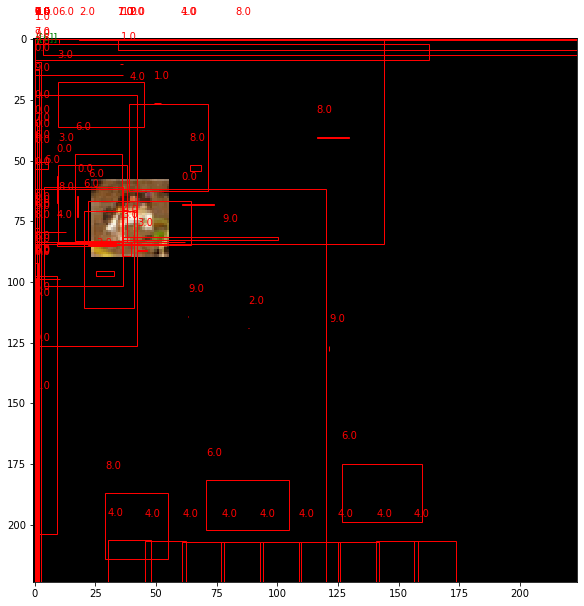

In [74]:
show(image[0],label[0],y_decoded[0])

In [109]:
a = np.array([[1,2,3],[4,5,6]])

In [115]:
b  = np.array([[True],[False]])

In [118]:
b[:,0]

array([ True, False])

In [113]:
a[b]

array([[1, 2, 3]])

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('Model Name: ', model_name)
print('Test loss     : {:.5f}'.format(test_loss))
print('Test accuracy : {:.5f}'.format(test_acc))

# 과제: MobileNet 변형해 보기



In [67]:
x = tf.constant([[1, 2, 3],[4,5,6],[7,8,9]])
#y = tf.broadcast_to(x, [3, 3])
y = tf.expand_dims(tf.reduce_sum(x, axis=-1), axis=-1)
a = tf.math.exp(x)

NotFoundError: Could not find valid device for node.
Node:{{node Exp}}
All kernels registered for op Exp :
  device='XLA_GPU'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_BFLOAT16, DT_COMPLEX128, DT_HALF]
  device='XLA_CPU'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_BFLOAT16, DT_COMPLEX128, DT_HALF]
  device='XLA_CPU_JIT'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_BFLOAT16, DT_COMPLEX128, DT_HALF]
  device='XLA_GPU_JIT'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_BFLOAT16, DT_COMPLEX128, DT_HALF]
  device='CPU'; T in [DT_COMPLEX128]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_COMPLEX128]
  device='GPU'; T in [DT_COMPLEX64]
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_FLOAT]
 [Op:Exp]

In [ ]:
ssd_input_gen = SSDInputEncodingGenerator(IMG_SIZE, 
                 IMG_SIZE, 
                 layer_width=layer_width, 
                 n_classes=n_classes, 
                 num_boxes=num_boxes, 
                 s_max=s_max, 
                 s_min=s_min, 
                 aspect_ratio=aspect_ratio, 
                 pos_iou_threshold=pos_iou_threshold,
                 neg_iou_threshold=neg_iou_threshold,
                 background_id=10,
                 images=x_test,
                 labels=y_test,                 
                batch_size=32)